In [290]:
!pip install textsearch
!pip install contractions
!pip install textsearch
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [291]:
import pandas as pd

df = pd.read_csv('/content/2021_Cities_Water_Security_Risks.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Questionnaire Name                       2349 non-null   object
 1   Account Number                           2349 non-null   int64 
 2   Account Name                             2349 non-null   object
 3   Country                                  2349 non-null   object
 4   CDP Region                               2349 non-null   object
 5   ParentSection                            2349 non-null   object
 6   Section                                  2349 non-null   object
 7   Question Number                          2349 non-null   object
 8   Question Name                            2349 non-null   object
 9   Row Number                               2349 non-null   int64 
 10  Water security risk drivers              2137 non-null   obj

In [292]:
df.head(5)

,Questionnaire Name,Account Number,Account Name,Country,CDP Region,ParentSection,Section,Question Number,Question Name,Row Number,Water security risk drivers,Anticipated timescale,Estimated magnitude of potential impact,Estimated probability of impact,Risk description
0,Cities 2021,1093,"City of Atlanta, GA",United States of America,North America,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,1,Increased water stress,Short-term (by 2025),Serious,NaN,The city depends on one river for water supply...
1,Cities 2021,1093,"City of Atlanta, GA",United States of America,North America,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,2,Higher water prices,Current,Serious,NaN,The water cost burden is felt across all ZIP c...
2,Cities 2021,1184,"City of Austin, TX",United States of America,North America,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,1,Increased water stress,Short-term (by 2025),Extremely serious,High,Central Texas is drought prone and we depend o...
3,Cities 2021,1499,Ajuntament de Barcelona,Spain,Europe,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,1,Increased water stress,Current,Serious,Medium-high,The downscaling of the climate projections at ...
4,Cities 2021,1499,Ajuntament de Barcelona,Spain,Europe,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,2,Declining water quality,Medium-term (by 2050),Less Serious,Medium,A reduction in water resources availability c...


In [293]:
df = df[['Country','Account Name', 'CDP Region','Water security risk drivers', 'Risk description']]
df['description'] = df['Risk description'].map(str)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 2348
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Country                      1914 non-null   object
 1   Account Name                 1914 non-null   object
 2   CDP Region                   1914 non-null   object
 3   Water security risk drivers  1914 non-null   object
 4   Risk description             1914 non-null   object
 5   description                  1914 non-null   object
dtypes: object(6)
memory usage: 104.7+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [294]:
import nltk
import re
import numpy as np
import contractions

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['description']))
len(norm_corpus)

1914

In [295]:
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stop_words + ['one', 'two', 'three', 'four', 'five', 'get']
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(1914, 8160)

In [296]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(cv_matrix)
km

KMeans(max_iter=10000, n_clusters=6, n_init=100, random_state=42)

In [297]:
from collections import Counter

Counter(km.labels_)

Counter({0: 47, 1: 251, 2: 215, 3: 8, 4: 1381, 5: 12})

In [298]:
df['kmeans_cluster'] = km.labels_

In [299]:
df.head(5)

,Country,Account Name,CDP Region,Water security risk drivers,Risk description,description,kmeans_cluster
0,United States of America,"City of Atlanta, GA",North America,Increased water stress,The city depends on one river for water supply...,The city depends on one river for water supply...,4
1,United States of America,"City of Atlanta, GA",North America,Higher water prices,The water cost burden is felt across all ZIP c...,The water cost burden is felt across all ZIP c...,4
2,United States of America,"City of Austin, TX",North America,Increased water stress,Central Texas is drought prone and we depend o...,Central Texas is drought prone and we depend o...,4
3,Spain,Ajuntament de Barcelona,Europe,Increased water stress,The downscaling of the climate projections at ...,The downscaling of the climate projections at ...,1
4,Spain,Ajuntament de Barcelona,Europe,Declining water quality,A reduction in water resources availability c...,A reduction in water resources availability c...,4


In [300]:
df['city'] = df['Account Name'].map(str)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 2348
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Country                      1914 non-null   object
 1   Account Name                 1914 non-null   object
 2   CDP Region                   1914 non-null   object
 3   Water security risk drivers  1914 non-null   object
 4   Risk description             1914 non-null   object
 5   description                  1914 non-null   object
 6   kmeans_cluster               1914 non-null   int32 
 7   city                         1914 non-null   object
dtypes: int32(1), object(7)
memory usage: 127.1+ KB


In [301]:
df.head(5)

,Country,Account Name,CDP Region,Water security risk drivers,Risk description,description,kmeans_cluster,city
0,United States of America,"City of Atlanta, GA",North America,Increased water stress,The city depends on one river for water supply...,The city depends on one river for water supply...,4,"City of Atlanta, GA"
1,United States of America,"City of Atlanta, GA",North America,Higher water prices,The water cost burden is felt across all ZIP c...,The water cost burden is felt across all ZIP c...,4,"City of Atlanta, GA"
2,United States of America,"City of Austin, TX",North America,Increased water stress,Central Texas is drought prone and we depend o...,Central Texas is drought prone and we depend o...,4,"City of Austin, TX"
3,Spain,Ajuntament de Barcelona,Europe,Increased water stress,The downscaling of the climate projections at ...,The downscaling of the climate projections at ...,1,Ajuntament de Barcelona
4,Spain,Ajuntament de Barcelona,Europe,Declining water quality,A reduction in water resources availability c...,A reduction in water resources availability c...,4,Ajuntament de Barcelona


In [302]:
city_clusters = (df[['Country','city','kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
city_clusters = city_clusters.copy(deep=True)

In [303]:
city_clusters.head(10)

,Country,city,kmeans_cluster
311,Brazil,Municipality of Recife,5
1040,Brazil,Prefeitura de Duque de Caxias,5
296,Brazil,Municipality of Fortaleza,5
2004,Brazil,Prefeitura de Goiás (Goiás Velho),5
772,Portugal,Município de Évora,5
162,Brazil,Municipality of Curitiba,5
1075,Portugal,Município de Braga,5
1074,Portugal,Município de Braga,5
312,Brazil,Municipality of Recife,5
465,Brazil,City of Salvador,5


In [304]:
feature_names = cv.get_feature_names()
topn_features = 30
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get cities belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    cities = city_clusters[city_clusters['kmeans_cluster'] == cluster_num]['city'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('City:', cities)
    print('-'*80)

CLUSTER #1
Key Features: ['de', 'la', 'en', 'el', 'agua', 'de la', 'que', 'de agua', 'del', 'se', 'por', 'los', 'las', 'es', 'en la', 'un', 'en el', 'con', 'para', 'suministro', 'lo', 'una', 'ciudad', 'agua potable', 'la ciudad', 'potable', 'cual', 'como', 'al', 'poblacin']
City: ['Alajuela', 'Gobierno Autónomo Municipal de Tarija', 'Municipalidad Cerro Navia', 'Junta Intermunicipal de Medio Ambiente Region Valles (JIMAV)', 'Municipalidad Cerro Navia', 'Junta Intermunicipal de la Región Norte del Estado de Jalisco (JINOR)', 'Ayuntamiento de Culiacán', 'Gobierno Municipal de Toluca de Lerdo', 'Junta Intermunicipal de la Región Norte del Estado de Jalisco (JINOR)', 'Gobierno Autónomo Municipal de Tarija', 'Junta Intermunicipal de Medio Ambiente de Sierra Occidental y Costa (JISOC)', 'Ayuntamiento de Cuernavaca', 'Ayuntamiento de Cuernavaca', 'Métropole de Rouen', 'Metropolitan Municipality of Lima', 'Alcaldía de Ríohacha', 'Aipromades Lago de Chapala', 'Aipromades Lago de Chapala', 'Muni

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [305]:
from gensim.models import FastText

tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, size=300, window=40, min_count=2, workers=4, sg=1, iter=100)

In [306]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [307]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 300)
doc_vecs_ft.shape

(1914, 300)

In [308]:
NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(doc_vecs_ft)

In [309]:
Counter(km.labels_)

Counter({0: 512, 1: 544, 2: 104, 3: 33, 4: 423, 5: 298})

In [310]:
df['kmeans_cluster'] = km.labels_
city_clusters = (df[['city', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending =False)
                  .groupby('kmeans_cluster').head(30))
city_clusters = city_clusters.copy(deep=True)

In [311]:
for cluster_num in range(NUM_CLUSTERS):
    city = city_clusters[city_clusters['kmeans_cluster'] == cluster_num]['city'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('City:', city)
    print('-'*80)

CLUSTER #1
City: ['General Pueyrredon', 'Saiki City', 'Reihoku Town', 'Minamioguni Town', 'Karsiyaka Municipality', 'Minamikyushu City', 'New Town Kolkata', 'Kirishima City', 'Town of Hanawa', 'Aira City', 'Municipio de Tierras Altas', 'Rourkela', 'Nakatane Town', 'Takashima City', 'Tokunoshima Town', 'Town of Yabuki', 'Higashine City', 'Balikesir Metropolitan Municipality', 'Imabari City', 'Namie Town', 'South Gloucestershire Council', 'Kamiamakusa City', 'Santa Ana (Costa Rica)', 'Busbanza', 'Kani City', 'Prefeitura de Monteiro Lobato', 'City of Shimada', 'Prefeitura de Canápolis', 'Iwata City', 'Kitahiroshima City']
--------------------------------------------------------------------------------
CLUSTER #2
City: ['Legazpi City', 'Yala City Municipality', 'Legazpi City', 'Surat Municipal Corporation', 'Surat Municipal Corporation', 'Surat Municipal Corporation', 'Richmond Council', 'City of Encinitas, CA', 'Boulder County, CO', 'Surat Municipal Corporation', 'Sukabumi City', 'Surat M

In [312]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

In [313]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [314]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hierarchical_clusters(linkage_matrix, city_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    city = city_data['city'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=city,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: city[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('city_hierachical_clusters.png', dpi=200)

In [315]:
linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

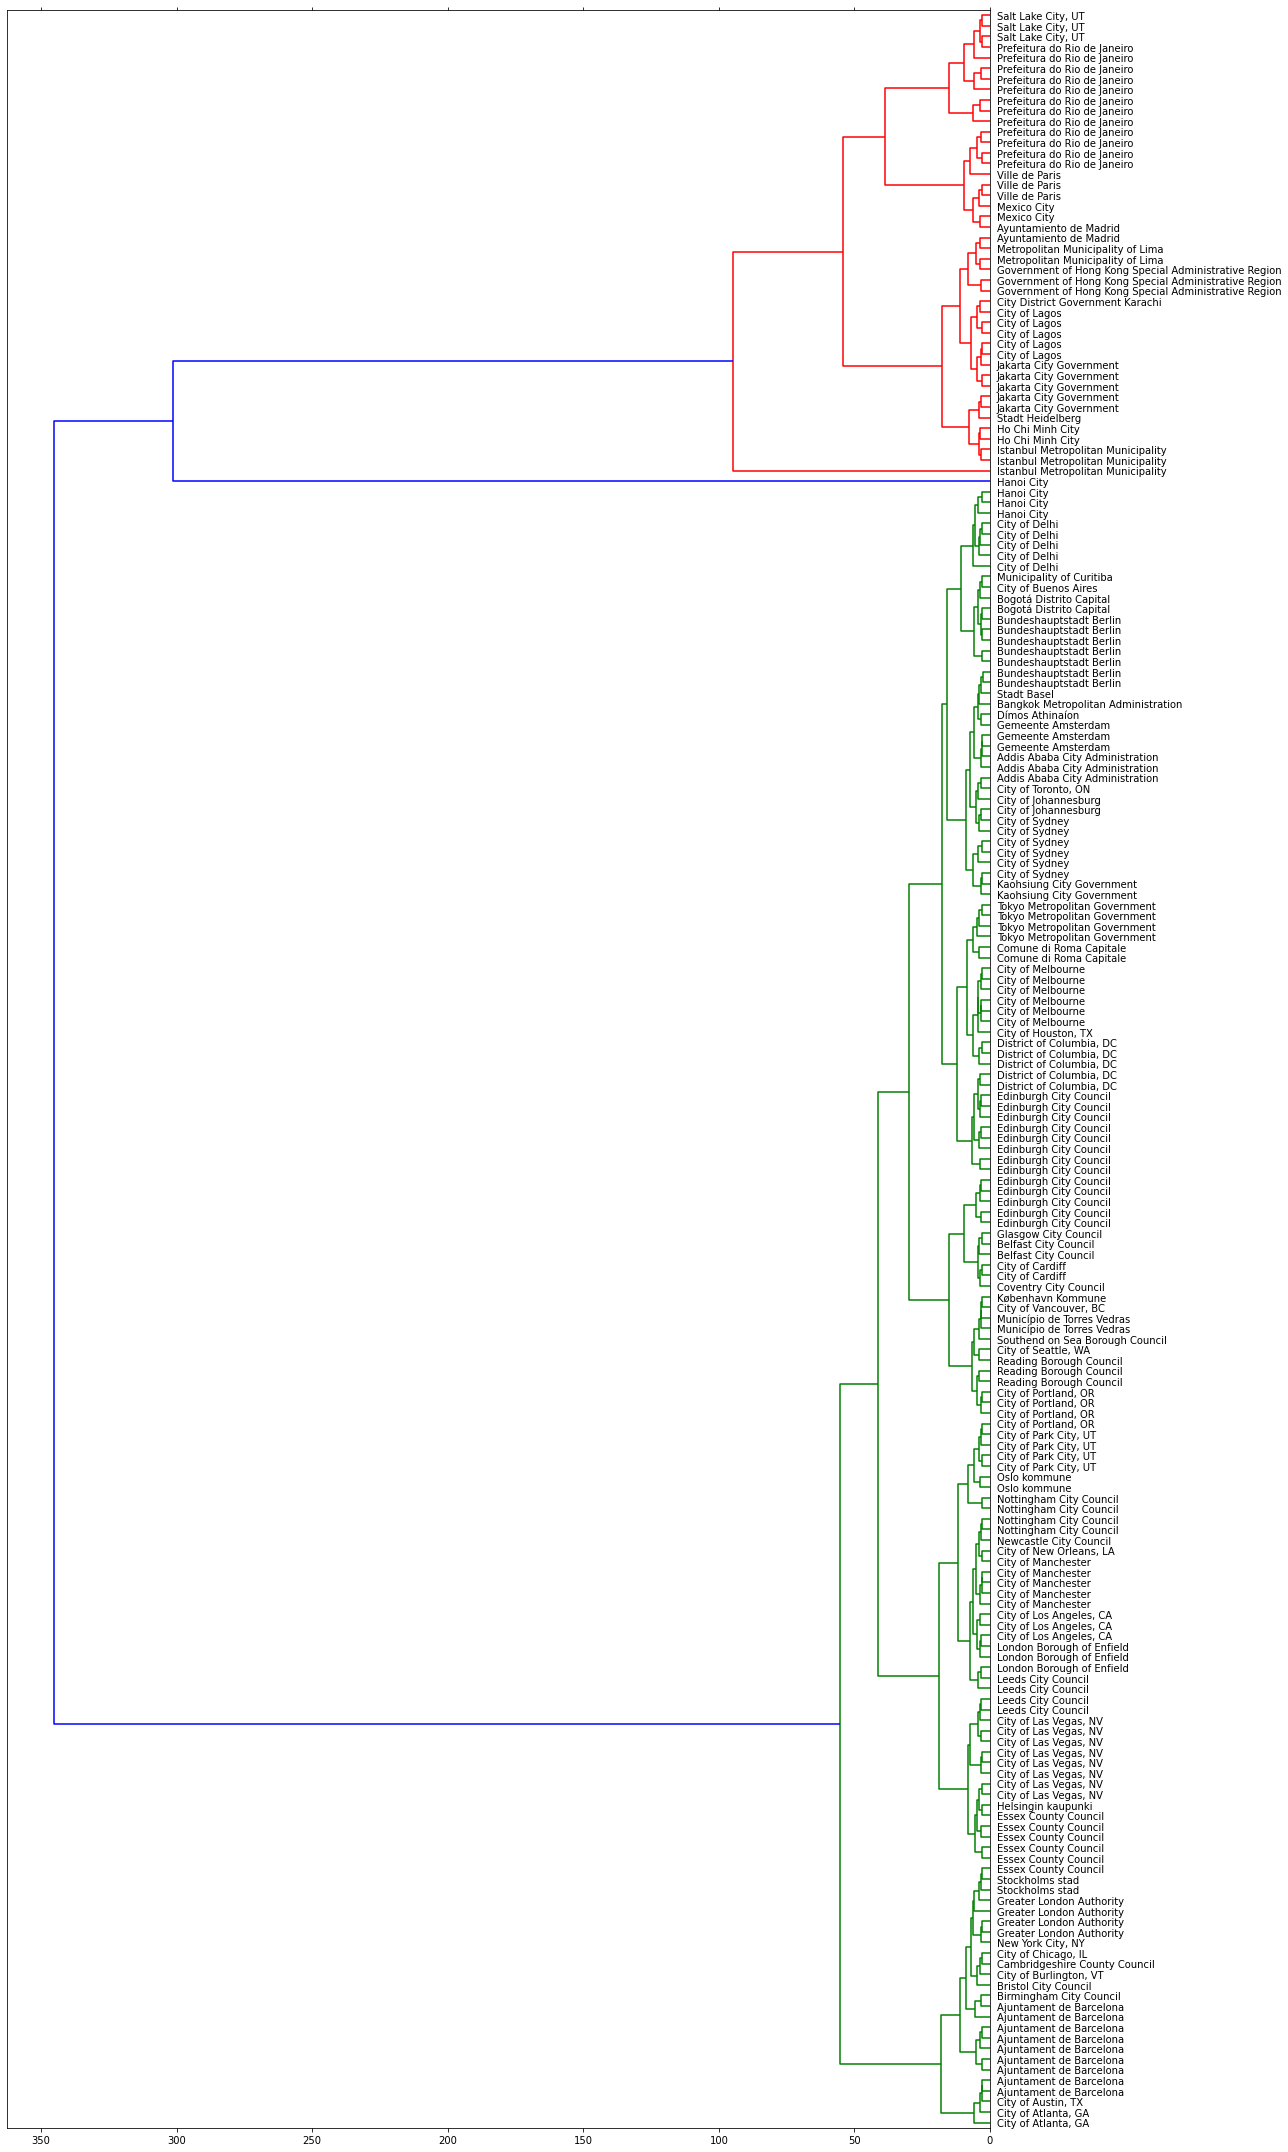

In [316]:
plot_hierarchical_clusters(linkage_matrix,
                           p=200,
                           city_data=df,
                           figure_size=(18, 30))

In [317]:

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

In [318]:
# Groupby by city
city= df.groupby("city")

# Summary statistic of all countries
city.describe().head(10)

kmeans_cluster                                \
                                         count mean       std  min  25%  50%   
city                                                                           
Aarhus Kommune                             1.0  0.0       NaN  0.0  0.0  0.0   
Abington Township, PA                      3.0  2.0  1.732051  1.0  1.0  1.0   
Abuja Federal Capital Territory            3.0  3.0  1.732051  1.0  2.5  4.0   
Accra Metropolitan Assembly                1.0  4.0       NaN  4.0  4.0  4.0   
Adana Metropolitan Municipality            1.0  0.0       NaN  0.0  0.0  0.0   
Addis Ababa City Administration            3.0  2.0  1.732051  1.0  1.0  1.0   
Aipromades Lago de Chapala                 3.0  5.0  0.000000  5.0  5.0  5.0   
Aira City                                  1.0  0.0       NaN  0.0  0.0  0.0   
Ajuntament de Barcelona                    9.0  2.0  1.500000  1.0  1.0  1.0   
Ajuntament de València                     1.0  0.0       NaN  0.0  0.0  0.0   

                                           
                                 75%  max  
city                                       
Aarhus Kommune                   0.0  0.0  
Abington Township, PA            2.5  4.0  
Abuja Federal Capital Territory  4.0  4.0  
Accra Metropolitan Assembly      4.0  4.0  
Adana Metropolitan Municipality  0.0  0.0  
Addis Ababa City Administration  2.5  4.0  
Aipromades Lago de Chapala       5.0  5.0  
Aira City                        0.0  0.0  
Ajuntament de Barcelona          4.0  4.0  
Ajuntament de València           0.0  0.0

**Count represents for how many row in each city, for example, city " Ajuntament de Barcelona" has 9 rows (Row Number), so the count here is 9.**

In [319]:
city.mean().sort_values(by="kmeans_cluster",ascending=False).head(10)

,kmeans_cluster
city,
Municipalidad de Magdalena del Mar,5.0
Municipio de Iztapa,5.0
Junta Intermunicipal de Medio Ambiente Region Valles (JIMAV),5.0
Municipalidad de Tampico,5.0
Municipalidad de Vitacura,5.0
Ocú,5.0
Junta Intermunicipal de Medio Ambiente de Sierra Occidental y Costa (JISOC),5.0
Municipality of Ambato,5.0
Gámeza,5.0


**There are 6 optimal clusters according to Risk description, for label:**
- Lable 0 for cluster 1
- Lable 1 for cluster 2
- Label 2 for cluster 3
- Lable 3 for cluster 4
- Lable 4 for cluster 5
- Lable 5 for cluster 6

So the highest cluster is cluster 6 with lable 5

In [ ]:
#plt.figure(figsize=(20,10))
#city.max().sort_values(by="kmeans_cluster",ascending=False)["kmeans_cluster"].plot.bar()
#plt.xticks(rotation=50)
#plt.xlabel("Risk description belongs to their cluster")
#plt.ylabel("Clusters")
#plt.show()

- **Word cloud for cluster 1 (lable of cluster is 0)**


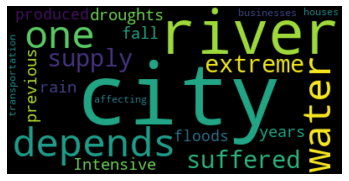

In [320]:
# Start with one review:
text_cluster_1 = df.description[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_cluster_1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [321]:
wordcloud.to_file("/content/cluster_1.png")

- **Word cloud for cluster 2**

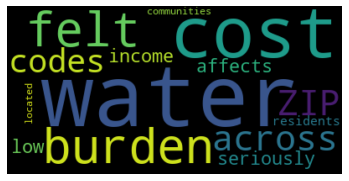

In [322]:
# Start with one review:
text_cluster_2 = df.description[1]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_cluster_2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [323]:
wordcloud.to_file("/content/cluster_2.png")

- **Word cloud for cluster 3**

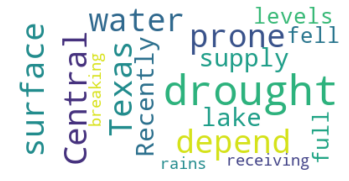

In [324]:
# lower max_font_size, change the maximum number of word and lighten the background:
text_cluster_3 = df.description[2]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_cluster_3)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [325]:
# Save the image in the img folder:
wordcloud.to_file("/content/cluster_3.png")

- **Word cloud for cluster 4**

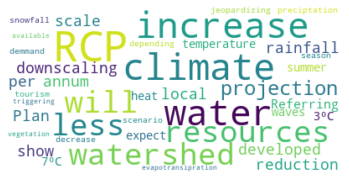

In [326]:
# lower max_font_size, change the maximum number of word and lighten the background:
text_cluster_4 = df.description[3]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_cluster_4)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [327]:
# Save the image in the img folder:
wordcloud.to_file("/content/cluster_4.png")

- **Word cloud for cluster 5**

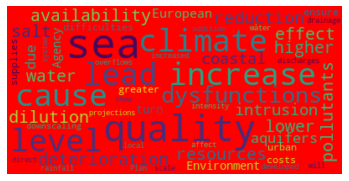

In [328]:
# lower max_font_size, change the maximum number of word and lighten the background:
text_cluster_5 = df.description[4]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="red").generate(text_cluster_5)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [329]:
wordcloud.to_file("/content/cluster_5.png")

- **Word cloud for cluster 6**

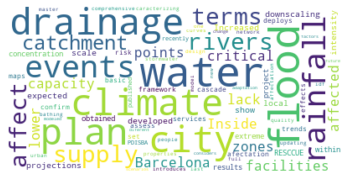

In [330]:
# lower max_font_size, change the maximum number of word and lighten the background:
text_cluster_6 = df.description[5]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_cluster_6)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [331]:
wordcloud.to_file("/content/cluster_6.png")

# Second part:  CLUSTERS IN MAP (BY COUNTRIES)

In [332]:
!pip install geopandas

In [333]:
import geopandas as gpd

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(f"{type(df_world)}, {df_world.geometry.name}")
print(df_world.head())
print(df_world.geometry.geom_type.value_counts())

<class 'geopandas.geodataframe.GeoDataFrame'>, geometry
     pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
Polygon         148
MultiPolygon     29
dtype: int64


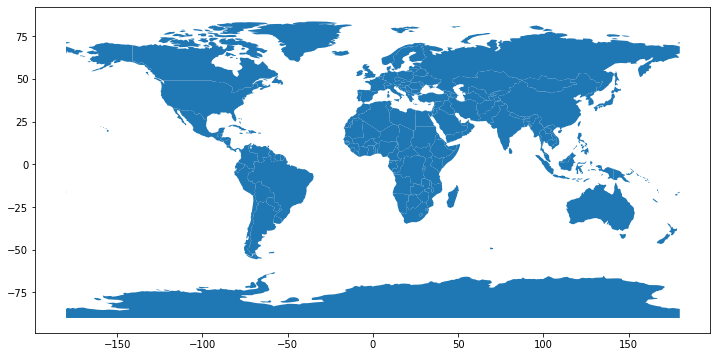

In [334]:
df_world.plot(figsize=(20,6))

## Merge 2 datasets, one is Cluster of risk description, another one is country geographic (df_world) based on the name of countries (name column)

In [335]:
# Change name of variable 'Country' to  'name' in order to merge 2 datasets
df['name'] =df["Country"]
df.head(5)

,Country,Account Name,CDP Region,Water security risk drivers,Risk description,description,kmeans_cluster,city,name
0,United States of America,"City of Atlanta, GA",North America,Increased water stress,The city depends on one river for water supply...,The city depends on one river for water supply...,4,"City of Atlanta, GA",United States of America
1,United States of America,"City of Atlanta, GA",North America,Higher water prices,The water cost burden is felt across all ZIP c...,The water cost burden is felt across all ZIP c...,4,"City of Atlanta, GA",United States of America
2,United States of America,"City of Austin, TX",North America,Increased water stress,Central Texas is drought prone and we depend o...,Central Texas is drought prone and we depend o...,1,"City of Austin, TX",United States of America
3,Spain,Ajuntament de Barcelona,Europe,Increased water stress,The downscaling of the climate projections at ...,The downscaling of the climate projections at ...,1,Ajuntament de Barcelona,Spain
4,Spain,Ajuntament de Barcelona,Europe,Declining water quality,A reduction in water resources availability c...,A reduction in water resources availability c...,1,Ajuntament de Barcelona,Spain


In [336]:
 data_merge = pd.merge(df_world, df, on=["name"])
 data_merge.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country,Account Name,CDP Region,Water security risk drivers,Risk description,description,kmeans_cluster,city
0,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,"City of Vancouver, BC",North America,Increased water stress,Reduced snowpack in winter could reduce storag...,Reduced snowpack in winter could reduce storag...,1,"City of Vancouver, BC"
1,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,"City of Toronto, ON",North America,Question not applicable,Question not applicable,Question not applicable,0,"City of Toronto, ON"
2,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,"City of Calgary, AB",North America,Increased water stress,"Reliable, secure, high quality water supplies ...","Reliable, secure, high quality water supplies ...",1,"City of Calgary, AB"
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,"City of Calgary, AB",North America,Increased water stress,Managing water in time of shortage: Potential ...,Managing water in time of shortage: Potential ...,1,"City of Calgary, AB"
4,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,"City of Calgary, AB",North America,Drought,Future changes to water availability due to ch...,Future changes to water availability due to ch...,1,"City of Calgary, AB"


In [337]:
data_merge.plot(column="kmeans_cluster", ax=ax, cmap='OrRd', 
                     legend=True, legend_kwds={"label": "Cluters", "orientation":"horizontal"})
ax.set_title("Countries Vs Clusters")

Text(0.5, 1.0, 'Countries Vs Clusters')

<Figure size 432x288 with 0 Axes>

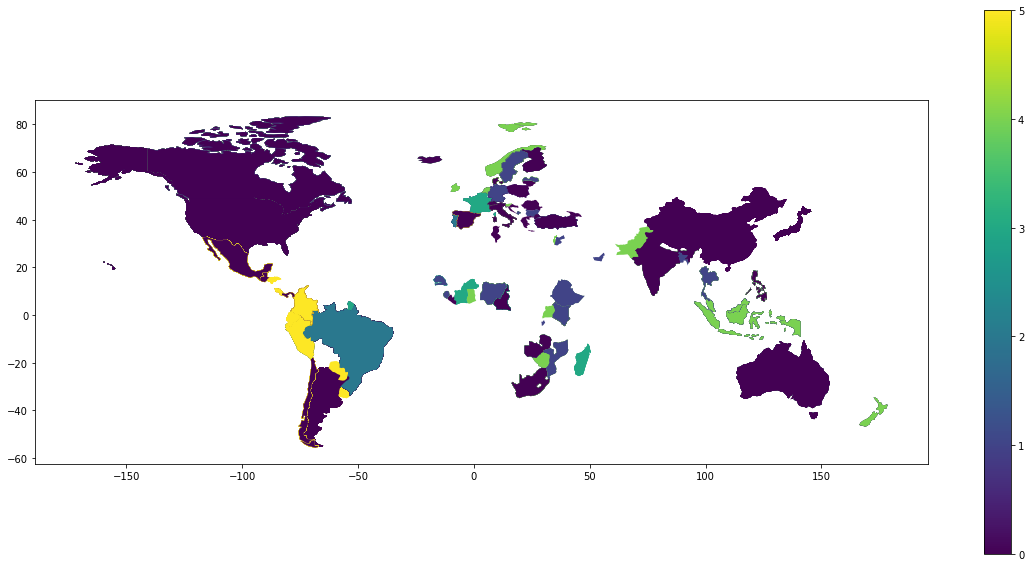

In [338]:
#data_merge = data_merge[(data_merge.kmeans_cluster>=0) & (data_merge.name!="Antarctica")]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
data_merge.plot(column='kmeans_cluster', ax=ax, legend=True)

In [340]:
!pip install mapclassify

In [349]:
# Assessing missing value in map
#data_merge.plot(column='city', missing_kwds={'color': 'lightgrey'});

#data_merge.plot(
    #column="city",
    #legend=True,
    #scheme="quantiles",
    #figsize=(15, 10),
    #missing_kwds={
        #"color": "lightgrey",
        #"edgecolor": "red",
        #"hatch": "///",
        #"label": "Missing values",},);
